# Week 5 Exercise 6
## Create a High Cost Risk Score

In [1]:
#importing necessary libraries
import pandas as pd


In [2]:

#reading the excel file
df = pd.read_excel('w5e4_patient_cost_forecast_oe.xlsx',index_col='id')

In [4]:

#get the information aout the dataframe
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 22632 entries, 53e40e98-c764-53a4-aaf6-6318a3c3c95d to 9fdfb702-0f46-8899-fe8c-363733532bb6
Data columns (total 140 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    first                                      object 
 1    last                                       object 
 2    city                                       object 
 3    state                                      object 
 4    county                                     object 
 5    fips                                       int64  
 6    lat                                        float64
 7    lon                                        float64
 8    birthdate                                  object 
 9    marital                                    object 
 10   race                                       object 
 11   ethnicity                                  object 
 12   gender                   

## Feature engineering: RFM (recency, frequency, monetary)?

## Machine Learning 

# Divide the dataset into labels (y) and samples/predictors (X)

 One option is to focus on total cost
 Median (50% percentile) split
 
 y = (df['cost_total_2yr'] > df['cost_total_2yr'].quantile(0.5)).astype('int')

 Another option is to focus on the OE ratio (i.e., above average or not)
 When focusing on the OE ratio, can either be a median/quantile split...
 
y = (df['cost_oe_ratio'] > df['cost_oe_ratio'].quantile(0.50)).astype('int')

 Or can be a threshold... I chose to go with a threshold and an OE greater than 2 (i.e., 2 times above average for the reference group)

In [6]:
#create a new label y that is true if the cost_forecast_oe_ratio is greater than 2
#function astype('int') converts True to 1 and False to 0
y = (df['cost_forecast_oe_ratio'] > 2).astype('int')
y.value_counts()

0    17297
1     5335
Name: cost_forecast_oe_ratio, dtype: int64

In [8]:
# Set X to features that may explain utilization (and overall cost score)
# Note: Just picked everything related to encounter utilization: all numof_enc columns
cols_numof = [col for col in df.columns if 'numof_enc' in col]
X = df[cols_numof]
X = pd.concat([X, df['numof_procedures_2yr']], axis=1)

In [9]:
# Split into test and train for both X (predictors) and y (targets/labels)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [10]:
# Run a number of models and check accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

models = {
    'LogisticRegression': LogisticRegression(random_state=0, solver='liblinear', max_iter=500),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=30),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print('Accuracy of {0}: {1}'.format(name, model.score(X_test, y_test)))


#choose the best model based on the accuracy score of above models

for name, model in models.items():
    if model.score(X_test, y_test) == max([model.score(X_test, y_test) for name, model in models.items()]):
        best_model = model
        print('Best model is {0} with accuracy of {1}'.format(name, model.score(X_test, y_test)))


Accuracy of LogisticRegression: 0.88016967126193
Accuracy of DecisionTreeClassifier: 0.8867090844821491
Accuracy of RandomForestClassifier: 0.9040296924708378
Best model is RandomForestClassifier with accuracy of 0.9040296924708378


## Create, describe, and save the risk (utilization) score

In [11]:
# Get the probabilities for both classes: 0 in col 1, and 1 in col 1
result = model.predict_proba(X)
df['risk_score_cost'] = result[:,1] # only need probability for 1 (column 2, but zero indexed)

# Round and rescale to be percentage (i.e., multiple by 100)
df['risk_score_cost'] = df['risk_score_cost'].astype(float).round(4) * 100

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22632 entries, 53e40e98-c764-53a4-aaf6-6318a3c3c95d to 9fdfb702-0f46-8899-fe8c-363733532bb6
Columns: 141 entries, first to risk_score_cost
dtypes: bool(12), float64(43), int64(53), object(33)
memory usage: 23.2+ MB


In [13]:
df['risk_score_cost'].describe()

count    22632.000000
mean        23.413968
std         37.102163
min          0.000000
25%          0.000000
50%          1.000000
75%         31.140000
max        100.000000
Name: risk_score_cost, dtype: float64

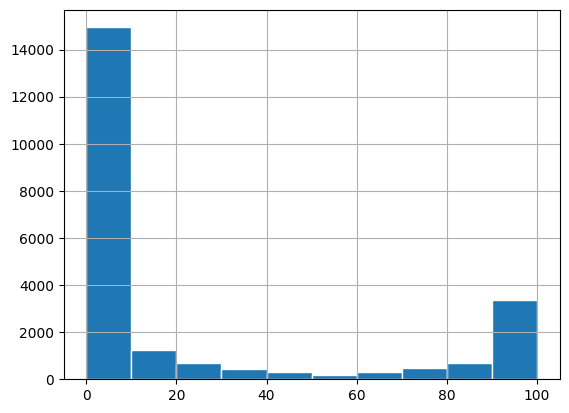

In [14]:
import matplotlib.pyplot as plt
df['risk_score_cost'].hist(edgecolor='white')
plt.show()

## Final list of features and feature importance from the model

In [15]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 22632 entries, 53e40e98-c764-53a4-aaf6-6318a3c3c95d to 9fdfb702-0f46-8899-fe8c-363733532bb6
Data columns (total 141 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    first                                      object 
 1    last                                       object 
 2    city                                       object 
 3    state                                      object 
 4    county                                     object 
 5    fips                                       int64  
 6    lat                                        float64
 7    lon                                        float64
 8    birthdate                                  object 
 9    marital                                    object 
 10   race                                       object 
 11   ethnicity                                  object 
 12   gender                   

In [16]:
# Display feature importances... remmber this is just importance, not direction (i.e., pos or neg)
feature_importances = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

In [17]:
feature_importances.head(20)

,importance
numof_procedures_2yr,0.406800
numof_enc_ambulatory_2yr,0.218739
numof_enc_outpatient_2yr,0.182388
numof_enc_emergency_2yr,0.056496
numof_enc_wellness_2yr,0.041913
numof_enc_urgentcare_2yr,0.041354
numof_enc_inpatient_2yr,0.025244
numof_enc_snf_2yr,0.009944
numof_enc_virtual_2yr,0.009542
numof_enc_hospice_2yr,0.004952


## Output

In [16]:
df.to_excel('w5e6_patient_risk_score_cost.xlsx')